Реализовать двухслойную полносвязную нейросетку на чистом TF.
Как функцию активации можете использовать что хотите. Размер тоже на ваше усмотрение. 
Предлагаю сделать по образу и подобию тетрадки с пары.

Для следующего дата сета:
    

In [63]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [5]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 1s 0us/step


In [80]:
num_classes = 10   # число классов
num_features = 784
num_inner = 128

In [9]:
X_train = X_train.reshape(X_train.shape[0], num_features) / 255
X_test = X_test.reshape(X_test.shape[0], num_features) / 255

In [11]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [85]:
W_1 = tf.Variable(tf.random.normal([num_features, num_inner], dtype='float64'), dtype='float64')
b_1 = tf.Variable(tf.random.normal([num_inner], dtype='float64'), dtype='float64')

W_2 = tf.Variable(tf.random.normal([num_inner, num_classes], dtype='float64'), dtype='float64')
b_2 = tf.Variable(tf.random.normal([num_classes], dtype='float64'), dtype='float64')

In [15]:
def tlnet(X):
    return tf.math.softmax((X @ W_1 + b_1) @ W_2 + b_2)

In [46]:
def logloss(p_pred, y_true):
    p_pred = tf.clip_by_value(p_pred, 1e-9, 1.)
    p_pred = tf.cast(tf.math.log(p_pred), dtype=tf.float64)
    y_true = tf.cast(y_true, dtype=tf.float64)
    return -tf.reduce_mean(tf.reduce_sum(y_true * p_pred, axis=1)) 

In [71]:
def accuracy(p_pred, y_true):
    preds = tf.argmax(p_pred, axis=1)
    true = tf.argmax(y_true, axis=1)
    acc = tf.reduce_mean(tf.cast(preds == true, 'float64'))
    return acc

In [88]:
learning_rate = 1e-4
optimizer = tf.optimizers.Adam(learning_rate)

In [48]:
def model_train(X, Y):

    with tf.GradientTape() as g:
        pred = tlnet(X)
        loss = logloss(pred, Y)
    
    gradients = g.gradient(loss, [W_1, b_1, W_2, b_2])
    optimizer.apply_gradients(zip(gradients, [W_1, b_1, W_2, b_2]))
    pass

In [22]:
# создали объект с данными для обучения 
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# перемешали данные с окном в 5000 и сделали кучу батчей размера 512 
train_data = train_data.shuffle(5000).batch(512)

In [23]:
from IPython import display

def visualize(l1,l2, h1, h2):
    plt.figure(figsize=(20,5)) 
    epo_range = range(1,len(h1)+1)
    tick_range = range(1,len(h1)+1,2)
    plt.subplot(1,2,1)
    plt.title('Learning loss')
    plt.plot(epo_range,l1, label='train set')
    plt.plot(epo_range,l2, label='valid set')
    plt.grid()
    plt.xticks(tick_range)
    plt.legend(title = 'Loss at:')
    
    plt.subplot(1,2,2)
    plt.title('Learning accuracy')
    plt.plot(epo_range,h1, label='train set')
    plt.plot(epo_range,h2, label='valid set')
    plt.grid()
    plt.xticks(tick_range)
    plt.ylim(0, 1.)
    plt.legend(title = 'Accuracy at:')
    
    display.clear_output(wait=True)
    plt.show()

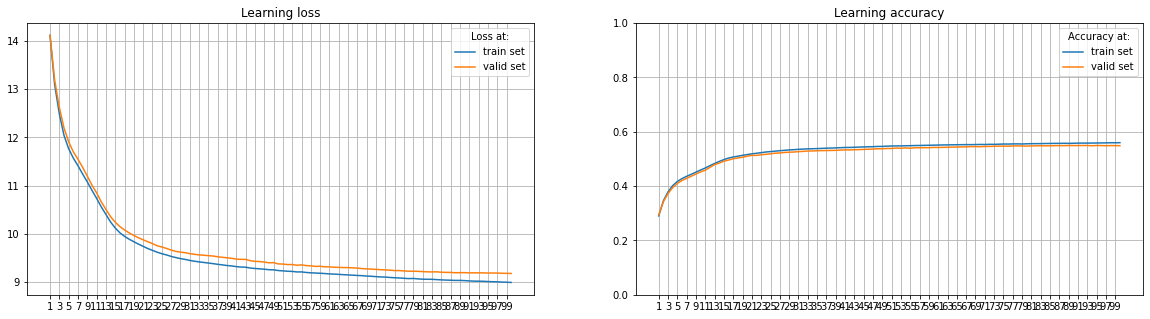

In [89]:
epochs = 100           # число эпох 
training_steps = 1000  # сколько раз на эпохе теребить генератор батчей

# Вектора для метрик
loss_test, loss_train  = [ ], [ ] 
acc_test, acc_train = [ ], [ ]

for i in range(epochs):
    
    # Проходимся по всем батчам
    for batch_x, batch_y in train_data.take(training_steps):
        
        model_train(batch_x, batch_y)
        
    
    # в конце эпохи считаем метрики
    p_train = tlnet(X_train)
    p_test = tlnet(X_test)
    
    loss_train.append(logloss(p_train, y_train))
    loss_test.append(logloss(p_test, y_test))
    
    acc_train.append(accuracy(p_train, y_train))
    acc_test.append(accuracy(p_test, y_test))
    
    # визуализируем
    visualize(loss_train, loss_test, acc_train, acc_test) 